In [ ]:
# 20230915 env2s 3classes ch2：0 represents angii，1 represents control，2 represents iso
# dropout_rate = 0.5  weight_decay = 2E-4  drop_connect_rate = 0.3
import os
import math
import pandas as pd
import csv
# import argparse

import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torch.optim.lr_scheduler as lr_scheduler

from models.model_efficientnetv2_1ch import efficientnetv2_s as create_model
from utils.my_dataset import MyDataSet
from utils.utils_env2 import read_split_data, train_one_epoch, evaluate

In [ ]:
# Parameter settings
num_classes = 3
batch_size = 32
lr = 0.01
epochs = 30
lrf = 0.01
data_path = "/data1/user1/jxb/ch2_6.19-10.15"   # There is no need to divide train and val
weights = "../models/pre_efficientnetv2-s.pth"
freeze_layers = False    # Whether to freeze the weight
device = 'cuda:0'

dropout_rate = 0.5
weight_decay = 2E-4
drop_connect_rate = 0.3
date = "20230915"

In [3]:
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:
        os.makedirs(path)

In [4]:
device = torch.device(device if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

using cuda:0 device.


In [4]:
# tb_writer = SummaryWriter()
# if os.path.exists("./weights") is False:
#     os.makedirs("./weights")

In [5]:
train_images_path, train_images_label, val_images_path, val_images_label = read_split_data(data_path)

38171 images were found in the dataset.
30538 images for training.
7633 images for validation.


In [ ]:
# Save the data information of the validation set
val_df = pd.DataFrame({
    "val_images_path": val_images_path,
    "val_images_label": val_images_label
})

mkdir('./val_images_info')
val_df.to_csv(f"./val_images_info/env2s_3classes_{date}.csv")

In [ ]:
data_transform = {
    "train": transforms.Compose([
        #transforms.ToPILImage(),
                                 #transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5,], [0.5,])]),   # 3 channels
    "val": transforms.Compose([
        #transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5,], [0.5,])])}

In [ ]:
train_dataset = MyDataSet(images_path=train_images_path,
                          images_class=train_images_label,
                          transform=data_transform["train"])

# Instantiate the validation dataset
val_dataset = MyDataSet(images_path=val_images_path,
                        images_class=val_images_label,
                        transform=data_transform["val"])

In [9]:
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

Using 8 dataloader workers every process


In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=nw,
                                           collate_fn=train_dataset.collate_fn)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=nw,
                                         collate_fn=val_dataset.collate_fn)

In [11]:
model = create_model(num_classes=num_classes, dropout_rate=dropout_rate, drop_connect_rate=drop_connect_rate).to(device)

In [12]:
if os.path.exists(weights):
    weights_dict = torch.load(weights, map_location=device)
    load_weights_dict = {k: v for k, v in weights_dict.items()
                         if model.state_dict()[k].numel() == v.numel()}
    print(model.load_state_dict(load_weights_dict, strict=False))
else:
    raise FileNotFoundError("not found weights file: {}".format(args.weights))

_IncompatibleKeys(missing_keys=['stem.conv.weight', 'head.classifier.weight', 'head.classifier.bias'], unexpected_keys=[])


In [ ]:
# Whether to freeze the weight
if freeze_layers:
    for name, para in model.named_parameters():
        # All weights are frozen except for the head
        if "head" not in name:
            para.requires_grad_(False)
        else:
            print("training {}".format(name))

In [ ]:
pg = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(pg, lr=lr, momentum=0.9, weight_decay=weight_decay)   # weight_decay is equivalent to lambda in L2 regularization
# Scheduler https://arxiv.org/pdf/1812.01187.pdf
lf = lambda x: ((1 + math.cos(x * math.pi / epochs)) / 2) * (1 - lrf) + lrf  # cosine
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)

In [14]:
# train_losses = []
# val_losses = []
# train_accs = []
# val_accs = []
# lrs = []

mkdir('./acc_and_loss')
mkdir('./weights')

best_acc = 0.0
for epoch in range(epochs):
    # train
    train_loss, train_acc = train_one_epoch(model=model,
                                            optimizer=optimizer,
                                            data_loader=train_loader,
                                            device=device,
                                            epoch=epoch)

    scheduler.step()

    # validate
    val_loss, val_acc = evaluate(model=model,
                                 data_loader=val_loader,
                                 device=device,
                                 epoch=epoch)

#     tags = ["train_loss", "train_acc", "val_loss", "val_acc", "learning_rate"]
#     tb_writer.add_scalar(tags[0], train_loss, epoch)
#     tb_writer.add_scalar(tags[1], train_acc, epoch)
#     tb_writer.add_scalar(tags[2], val_loss, epoch)
#     tb_writer.add_scalar(tags[3], val_acc, epoch)
#     tb_writer.add_scalar(tags[4], optimizer.param_groups[0]["lr"], epoch)
    
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)
#     train_accs.append(train_acc)
#     val_accs.append(val_acc)
#     lrs.append(optimizer.param_groups[0]["lr"])
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), f"./weights/env2s_3classes_{date}.pth")
 


    if not os.path.exists(f'./acc_and_loss/env2s_3classes_{date}.csv'):
        with open(f'./acc_and_loss/env2s_3classes_{date}.csv', mode="w", newline="", encoding="utf8") as cf:
            wf = csv.writer(cf)
            wf.writerow(['train_loss', 'val_loss', 'train_acc', 'val_acc', 'lr'])
            wf.writerow([train_loss, val_loss, train_acc, val_acc, optimizer.param_groups[0]["lr"]])
            
    else:
        with open(f'./acc_and_loss/env2s_3classes_{date}.csv', mode="a", newline="", encoding="utf8") as cfa:
            wf = csv.writer(cfa)
            wf.writerow([train_loss, val_loss, train_acc, val_acc, optimizer.param_groups[0]["lr"]])
        
        
# df = pd.DataFrame({"train_loss": train_losses,
#                    "val_loss": val_losses,
#                    "train_acc": train_accs,
#                    "val_acc": val_accs,
#                    "learning_rate": lrs})
# df.to_csv("./acc_and_loss/env2s_3classes_20230715.csv")

[valid epoch 29] loss: 1.250, acc: 0.766: 100%|██████████| 239/239 [00:42<00:00,  5.59it/s]


## 预测与评估

In [18]:
import os
import csv
import json
import numpy as np
import pandas as pd
import cv2
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score,precision_score,f1_score,recall_score
# from sklearn.metrics import roc_curve, auc

import torch
# from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns

from pylib.model_efficientnetv2_1ch import efficientnetv2_s as create_model

In [19]:
output_name = './output_csv/3cla_val_image_predict.csv'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5,], [0.5,])])

In [ ]:
# Output file: image name, v0-v1279, classified output, softmax output, classified category, real category
title1 = ['filename',]
title2 = ['v'+str(i) for i in range(1280)]
title3 = ['output0', 'output1', 'output2', 'prob0', 'prob1', 'prob2', 'pred_class', 'real_class']
title = title1 + title2 + title3

with open(output_name, mode="w", newline="", encoding="utf8") as cf:
    wf = csv.writer(cf)
    wf.writerow(title)

In [ ]:
model = create_model(num_classes=3).to(device)
model_weight_path = "./weights/env2s_3classes_20230915.pth"
model.load_state_dict(torch.load(model_weight_path, map_location=device))
model.eval()

val_df = pd.read_csv("./val_images_info/env2s_3classes_20230915.csv")
img_paths = val_df['val_images_path']
y_label = val_df['val_images_label']

for i in range(len(img_paths)):
    img = cv2.imread(img_paths[i], cv2.IMREAD_UNCHANGED).astype("float32")
    img = data_transform(img)
    img = torch.unsqueeze(img, dim=0)
    
    features_in_hook = []
    features_out_hook = []
    def hook(module, fea_in, fea_out):
        features_in_hook.append(fea_in)
        features_out_hook.append(fea_out)
        return None
    
    with torch.no_grad():
        model.head.classifier.register_forward_hook(hook=hook)
        model(img.to(device))
        predict = torch.softmax(features_out_hook[0][0], dim=0)
        predict_cla = torch.argmax(predict)  
        
    li = [img_paths[i].split("/")[-1],]            # Image filename
    li.extend(features_in_hook[0][0][0].tolist())  # 1280-dimensional feature vector before classifier
    li.extend(features_out_hook[0][0].tolist())   # Model output (logits)
    li.extend(predict.tolist())                   # Softmax output (probabilities)
    li.append(predict_cla.item())                 # Predicted class label
    li.append(y_label[i])
    
    with open(output_name, mode="a", newline="", encoding="utf8") as cfa:
        wf = csv.writer(cfa)
        wf.writerow(li) 

In [22]:
df = pd.read_csv('./output_csv/3cla_val_image_predict.csv')
y_label = list(df['real_class'])
y_pred = list(df['pred_class'])

Text(30.5, 0.5, 'true')

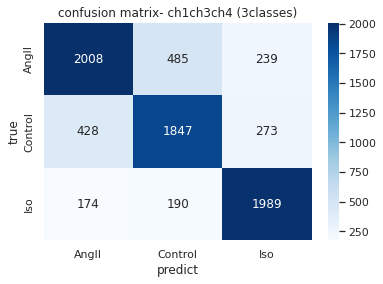

In [ ]:
cm = confusion_matrix(y_label, y_pred, labels=[0, 1, 2])

sns.set()
f,ax = plt.subplots()
sns.heatmap(cm, annot=True,ax=ax, cmap="Blues", fmt='g') 

ax.set_title('confusion matrix- ch1ch3ch4 (3classes)') 
ax.set_xticklabels(["AngII", "Control", "Iso"])
ax.set_yticklabels(["AngII", "Control", "Iso"])
ax.set_xlabel('predict') 
ax.set_ylabel('true') 
# plt.savefig("./image_output/env2s_cm_val_ch1ch3ch4_3cla.png", dpi=300)

In [24]:
weighted_precision = precision_score(y_label, y_pred, average='weighted')
weighted_recall = recall_score(y_label, y_pred, average='weighted')
weighted_f1 = f1_score(y_label, y_pred, average='weighted')
print("weighted-average scores:")
print(f"weighted precision: {weighted_precision}")
print(f"weighted recall: {weighted_recall}")
print(f"weighted f1: {weighted_f1}")

weighted-average scores:
weighted precision: 0.7649941116467437
weighted recall: 0.7656229529673785
weighted f1: 0.7649266387794478


## 测试集评估

In [25]:
import os
import csv
import json
import numpy as np
import pandas as pd
import cv2
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score,precision_score,f1_score,recall_score
# from sklearn.metrics import roc_curve, auc

import torch
# from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns

from pylib.model_efficientnetv2_1ch import efficientnetv2_s as create_model

In [26]:
output_name = './output_csv/3cla_test_image_predict.csv'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5,], [0.5,])])

In [ ]:
# Output file: image name, v0-v1279, classified output, softmax output, classified category, real category
title1 = ['filename',]
title2 = ['v'+str(i) for i in range(1280)]
title3 = ['output0', 'output1', 'output2', 'prob0', 'prob1', 'prob2', 'pred_class', 'real_class']
title = title1 + title2 + title3

with open(output_name, mode="w", newline="", encoding="utf8") as cf:
    wf = csv.writer(cf)
    wf.writerow(title)

In [ ]:
model = create_model(num_classes=3).to(device)
model_weight_path = "./weights/env2s_3classes_20230915.pth"
model.load_state_dict(torch.load(model_weight_path, map_location=device))
model.eval()

for cat in ['angii', 'control_selected', 'iso']:
    img_path = f'/data1/user1/jxb/ch2_6.19-10.15_testset/{cat}/'
    filenames = os.listdir(img_path)
    for fn in filenames:
        img = cv2.imread(os.path.join(img_path,fn), cv2.IMREAD_UNCHANGED).astype("float32")
        img = data_transform(img)
        img = torch.unsqueeze(img, dim=0)
        
        features_in_hook = []
        features_out_hook = []
        def hook(module, fea_in, fea_out):
            features_in_hook.append(fea_in)
            features_out_hook.append(fea_out)
            return None

        with torch.no_grad():
            model.head.classifier.register_forward_hook(hook=hook)
            model(img.to(device))
            predict = torch.softmax(features_out_hook[0][0], dim=0)
            predict_cla = torch.argmax(predict) 

        li = [fn,]                                     # Image filename
        li.extend(features_in_hook[0][0][0].tolist())  # 1280-dimensional feature vector before classifier
        li.extend(features_out_hook[0][0].tolist())    # Model output (logits)
        li.extend(predict.tolist())                    # Softmax output (probabilities)
        li.append(predict_cla.item())                  # Predicted class label
        if cat=='angii':
            li.append(0)
        elif cat=='control_selected':
            li.append(1)
        elif cat=='iso':
            li.append(2)
        
        with open(output_name, mode="a", newline="", encoding="utf8") as cfa:
            wf = csv.writer(cfa)
            wf.writerow(li)  

In [29]:
df = pd.read_csv('./output_csv/3cla_test_image_predict.csv')
y_label = list(df['real_class'])
y_pred = list(df['pred_class'])

Text(30.5, 0.5, 'true')

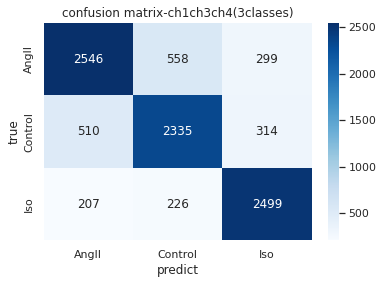

In [ ]:
cm = confusion_matrix(y_label,y_pred,labels=[0, 1, 2])

sns.set()
f,ax = plt.subplots()
sns.heatmap(cm, annot=True,ax=ax, cmap="Blues", fmt='g') 

ax.set_title('confusion matrix-ch1ch3ch4(3classes)') 
ax.set_xticklabels(["AngII", "Control", "Iso"])
ax.set_yticklabels(["AngII", "Control", "Iso"])
ax.set_xlabel('predict') 
ax.set_ylabel('true') 
# plt.savefig("./image_output/env2s_cm_test_ch1ch3ch4_3cla.png", dpi=300)

In [31]:
weighted_precision = precision_score(y_label, y_pred, average='weighted')
weighted_recall = recall_score(y_label, y_pred, average='weighted')
weighted_f1 = f1_score(y_label, y_pred, average='weighted')
print("weighted-average scores:")
print(f"weighted precision: {weighted_precision}")
print(f"weighted recall: {weighted_recall}")
print(f"weighted f1: {weighted_f1}")

weighted-average scores:
weighted precision: 0.7767683475996624
weighted recall: 0.7773330524541816
weighted f1: 0.7766931192584553
